## 因子策略

因子是什么？简单来说就是你选股票的时候得有一定的标准，这些标准就叫做因子。例如认为营收增长率高的公司就是好公司！


** 因子数据处理三步走：1.去极值 2.标准化 3.中性化 **

## 因子数据预处理

![title](./img/1.png)

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

In [2]:
data = pd.read_csv('data.csv',index_col=0,parse_dates=True)
data.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4323,1096.35,NaN,NaN
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82


### 极值处理方法


#### 分位数去极值

![title](./img/2.png)

In [3]:
col = 'AAPL.O'

In [4]:
def filter_extreme_percent(series,min=0.25,max=0.75):
    series = series.sort_values()
    q = series.quantile([min,max])
    return np.clip(series,q.iloc[0],q.iloc[1])

In [5]:
percentile = filter_extreme_percent(data[col])

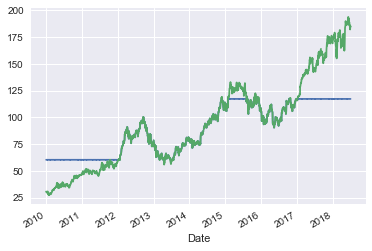

In [9]:
percentile.plot()
data[col].plot()

#### MAD又称为绝对值差中位数法

![title](./img/3.png)

- 数据集:(1, 1, 2, 2, 4, 6, 9)，它的中位数为2。
- 数据点到2的绝对偏差为(1, 1, 0, 0, 2, 4, 7)，该偏差列表的中位数为1（因为排序后的绝对偏差为(0, 0, 1, 1, 2, 4, 7)）
- 通常n都取1.4826，相对固定

In [10]:
def filter_extreme_mad(series,n):
    median = series.quantile(0.5)
    mad = ((series-median).abs()).quantile(0.5)
    max_range = median + n*mad
    min_range = median - n*mad
    return np.clip(series,min_range,max_range)

In [11]:
mad = filter_extreme_mad(data[col],1.4826)

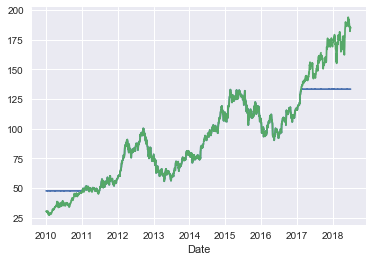

In [12]:
mad.plot()
data[col].plot()

#### 3sigma方法

![title](./img/4.png)

In [13]:
def filter_extreme_3sigma(series,n=3):
    mean = series.mean()
    std = series.std()
    max_range = mean + n*std
    min_range = mean - n*std
    return np.clip(series,min_range,max_range)    

In [14]:
sigma = filter_extreme_3sigma(data[col],1)

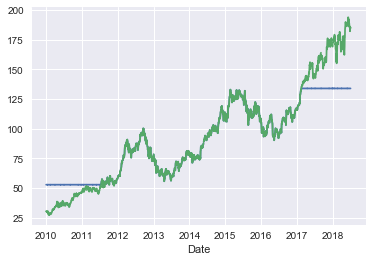

In [15]:
sigma.plot()
data[col].plot()

### 标准化操作

![title](./img/5.png)

In [16]:
def standardize(series):
    mean = series.mean()
    std = series.std()
    return (series - mean)/std

### 中性化

简单概述就是要 **提纯**

在量化交易中，我们会经常使用某种指标或者多种指标来对股票池进行筛选，这些用于选股的指标一般被称为因子。在使用这些因子进行选股时，有时会因为其它因子的影响，而导致选出来的股票具有一些我们不希望看到的偏向。

例如，市净率pb会与市值有很高的相关性，这时如果我们使用未进行市值中性化的市净率，选股的结果会比较集中。

（市净率（Price-to-Book Ratio，简称P/B PBR）指的是每股股价与每股净资产的比率。 市净率可用于股票投资分析，一般来说市净率较低的股票，投资价值较高，相反，则投资价值较低）

### 因子策略实例

- 1.查询获取选择PBR和市值数据
- 2.在数据中剔除掉停牌，ST，新股数据
- 3.对数据依次进行去极值，标准化，中性化处理
- 4.基于因子来进行选股策略